<IPython.core.display.Javascript object>


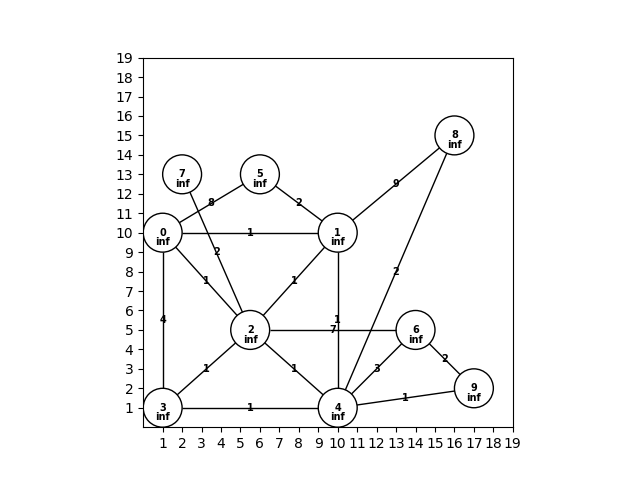

In [33]:
import numpy as np
import math 
import matplotlib.pyplot as plt
from matplotlib.table import table
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
from matplotlib.patches import Path
from matplotlib.patches import PathPatch
import ipywidgets as widgets 
from ipywidgets import interact

%matplotlib nbagg 

def inter_points(rad,x1,y1,x2,y2): 
    phi = math.atan2(y2-y1, x2-x1)
    x = x1 + rad * math.cos(phi)
    y = y1 + rad * math.sin(phi)
    return (x,y)

#estaría bien que fuera paralelo pero 
def mid_point(p1,p2): 
    (x1,y1) = p1
    (x2,y2) = p2
    return ((x1 + x2)/2.0,(y1 + y2)/2.0)
#el tercero son las posiciones de los vertices 
def crear_graf(n,ars,pos_vert,ax):
    rad = 1
    graf = [ [] for i in range(0,n)]
    #para la representacion de la grafia tengo que poner los vertices con su respectivo nodo 
    graf_rep = [[None,dict([])] for i in range(0,n)]
    for v in range(0,len(pos_vert)): 
        (x,y) = pos_vert[v]
        c = Circle((x,y),radius = rad,facecolor = 'white',edgecolor = 'black')
        anot = ax.annotate(str(v), (x, y),color='black', weight='bold', fontsize=7, ha='center', va='center')
        anot_dist = ax.annotate(str("inf"), (x, y-0.5),color='black', weight='bold', fontsize=7, ha='center', va='center')
        ax.add_patch(c)
        graf_rep[v][0] = (c,anot,anot_dist)
    for (i,j,w) in ars:
        #poner las lineas 
        xi,yi = graf_rep[i][0][0].get_center()
        xj,yj = graf_rep[j][0][0].get_center()
        linea = PathPatch(Path([inter_points(rad,xi,yi,xj,yj),inter_points(rad,xj,yj,xi,yi)]), facecolor='none', edgecolor='black')
        ax.add_patch(linea)
        ax.annotate(str(w),mid_point(graf_rep[i][0][0].get_center(),graf_rep[j][0][0].get_center()),color='black', weight='bold', fontsize=7, ha='center', va='center')
        graf[i].append((j,w))
        graf[j].append((i,w))
        #le asignamos la imagen a la linea
        graf_rep[i][1][j] = linea
        graf_rep[j][1][i] = linea 
    return (graf,graf_rep)
# take second element for sort
def takeSecond(elem):
    return elem[1]

def paso(graf,dist,heap,visitados,graf_rep,padre): 
    if not heap: 
        return
    #sacar del heap 
    heap.sort(key=takeSecond)
    (i,d) = heap[0]
    heap.pop(0)
    visitados.append(i)
    graf_rep[i][0][0].set(facecolor = 'red')
    if padre[i] != -1: 
        graf_rep[i][1][padre[i]].set(color = 'red')
    for (j,w) in graf[i]:  
        if j in visitados:
            continue
        if not j in dist: 
            heap.append((j,dist[i] + w)) 
            graf_rep[j][0][0].set(facecolor = 'orange')
            graf_rep[j][0][2].set(text = str(dist[i] + w))
            padre[j] = i
            graf_rep[j][1][padre[j]].set(color = 'orange')
            dist[j] = dist[i] + w
        elif dist[i] + w < dist[j]: 
            heap.remove((j,dist[j]))
            #eliminarlo del heap 
            dist[j] = dist[i] + w
            heap.append((j,dist[j])) 
            graf_rep[j][0][2].set(text = str(dist[i] + w))
            graf_rep[j][1][padre[j]].set(color = 'black')
            #pintar el anterior de negro si tiene
            padre[j] = i 
            graf_rep[j][1][padre[j]].set(color = 'orange')
    return (graf,dist,heap,visitados) 

class controls: 
    start_button = None 
    start_node_choice = None
    layout =  widgets.VBox([])
    st = None 
    start_node = 0 
    def next_button_handler(self,event): 
        self.st.update() 
    def start_button_handler(self,event):
        next_button = widgets.Button(description='Siguiente')
        next_button.on_click(self.next_button_handler)
        self.st.update_initial_v(self.start_node)
        self.layout.children = [next_button]
    def handle_slider_change(self,change):
        self.start_node = change.new
        
    def __init__(self,st,n): 
        start_button = widgets.Button(description='Start')
        start_button.on_click(self.start_button_handler)
        start_node_choice = widgets.BoundedIntText(value=0,min=0,max=n,step=1,description='Start node',disabled=False)
        start_node_choice.observe(self.handle_slider_change, names='value')
        self.layout.children = [start_button,start_node_choice]
        self.st = st 
        display(self.layout)
        
class state: 
    
    def __init__(self,n,ars,pos_vert,ax): 
        #necesita las posiciones de los vertices 
        self.graf,self.graf_rep = crear_graf(n,ars,pos_vert,ax)        
    def update(self):
        paso(self.graf,self.dist,self.heap,self.visitados,self.graf_rep,self.padre)
    def update_initial_v(self,initial): 
        print(initial)
        self.heap = [(initial,0)] 
        self.dist = dict()
        self.dist[initial] = 0 
        self.visitados = []  
        self.padre = [-1 for i in range(0,len(self.graf))]
        self.graf_rep[initial][0][0].set(facecolor = 'orange')
        self.graf_rep[initial][0][2].set(text = '0')
    
class cell: 
    def __init__(self): 
        self.ax = None
        self.fig = None
        self.maxim_x = None 
        self.maxim_y = None 
        self.st = None
        self.controls = None
    def main(self): 
        self.fig, self.ax = plt.subplots()
        self.maxim_x = 20
        self.maxim_y = 20
        plt.xticks(range(1,self.maxim_x))
        plt.yticks(range(1,self.maxim_y))
        plt.gca().set_aspect('equal', adjustable='box')
        pos_vert = [(1,10),(10,10),(5.5,5),(1,1),(10,1),(6,13),(14,5),(2,13),(16,15),(17,2)]
        ars = [(0,1,1),(0,3,4),(0,2,1),(1,2,1),(1,4,1),(2,4,1),(2,3,1),(3,4,1),(5,1,2),(5,0,8),(6,4,3),(6,2,7),(7,2,2),(8,1,9),(8,4,2),(4,9,1),(6,9,2)]
        self.st = state(len(pos_vert),ars,pos_vert,self.ax)
        plt.show()
        self.controls = controls(self.st,len(pos_vert))
    


c = cell()
c.main()